# Coding a neural network from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    activ_cache = Z
    return A, activ_cache

def relu(Z):
    A = np.maximum(0,Z)
    activ_cache = Z
    return A, activ_cache

In [3]:
def initialize(layers_dims): #ex argument : [12288, 5,5,5,1]
    
    L = len(layers_dims)
    
    params = {}
    
    for i in range(1, L):
        params['W' + str(i)] = np.random.randn(layers_dims[i], layers_dims[i-1]) * 0.001 #/ np.sqrt(layer_dims[i-1]) 
        params['b' + str(i)] = np.zeros((layers_dims[i],1))
    
    return params

In [4]:
np.random.seed(1)
initialize([2,4,1])

{'W1': array([[ 0.00162435, -0.00061176],
        [-0.00052817, -0.00107297],
        [ 0.00086541, -0.00230154],
        [ 0.00174481, -0.00076121]]), 'b1': array([[0.],
        [0.],
        [0.],
        [0.]]), 'W2': array([[ 0.00031904, -0.00024937,  0.00146211, -0.00206014]]), 'b2': array([[0.]])}

In [5]:
def linear_forward(A,W,b):
    linear_cache = A,W,b
    Z = np.dot(W,A) + b
    return Z, linear_cache

In [6]:
def linear_activation_forward(A_prev, W, b, activation): #type(activation) == string
    
    Z, linear_cache = linear_forward(A_prev, W, b)    
    
    if activation == "relu":
        A, activ_cache = relu(Z)
    elif activation == "sigmoid":
        A, activ_cache = sigmoid(Z)
    else:
        raise Exception('{activation} function is not known'.format(activation))

    cache = (linear_cache, activ_cache)
    
    return A, cache

In [7]:
def L_model(X, params, activations, final_activ):
    
    L = len(params) // 2
    caches = []
    
    A = X
    
    # L-1 premières couches
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, params['W' + str(l)], params['b' + str(l)], activations)
        caches.append(cache)
    
    # L-ième couche
    A, cache = linear_activation_forward(A, params['W' + str(L)], params['b' + str(L)], final_activ)
    caches.append(cache)
    
    Yhat = A
    
    return Yhat, caches
    # caches est une liste qui contient L tupples "cache", chacun contenant
    # 1) lin_cache (avec A_prev, matrice W de la couche, et b vecteur des biais de la couche)
    # 2) activ_cache (contenant juste Z de la couche)

In [8]:
def compute_cost(Yhat,Y):
    
    m = Y.shape[1]
    
    #moyenne des losses sous forme vectorielle. Renvoie un array.
    cost = (- 1. / m) * (np.dot(Y,np.log(Yhat).T) + np.dot((1 - Y),np.log(1 - Yhat).T))
    #retirer un 'niveau' de crochets
    cost = np.squeeze(cost)
    
    assert cost.shape == ()
    
    return cost

In [9]:
def linear_backward(dZ, lin_cache):
        
    A_prev, W, b = lin_cache
    
    m = A_prev.shape[1]

    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [10]:
def relu_backward(dA, Z):

    dA_copy = np.array(dA, copy=True)
    dA_copy[Z <= 0] = 0

    return dA_copy

In [11]:
def sigmoid_backward(dA, Z):
    s, _ = sigmoid(Z)
    dZ = dA * (s * (1 -s))
    return dZ

In [12]:
def lin_activation_backward(dA, cache, activation):
    
    lin_cache, activ_cache = cache
    Z = activ_cache
    
    if activation == "relu":
        dZ = relu_backward(dA, Z)

    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)

    dA_prev, dW, db = linear_backward(dZ, lin_cache)
    
    return dA_prev, dW, db

In [13]:
def L_model_backward(Yhat, Y, caches, activations, final_activ):
    
    grads = {}
    L = len(caches)
    m = Y.shape[1]
    #Y = Y.reshape(AL.shape)
    
    
    # dérivée de la cost function par rapport à Yhat
    dYhat = - (np.divide(Y, Yhat) - np.divide(1-Y, (1-Yhat))) 
    
    # descente de gradient pour les paramêtres de la dernière couche
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = lin_activation_backward(dYhat, current_cache, final_activ)
    
    # descente de gradient pour le reste des paramêtres des couches intermédiaires
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = lin_activation_backward(grads["dA" + str(l+1)], current_cache, activations)
        
    return grads

In [14]:
def update_params(params, grads, learning_rate=0.003):
    
    L = len(params) // 2
    
    for l in range(1, L +1):
        params['W' + str(l)] = params['W' + str(l)] - learning_rate * grads['dW' + str(l)]
        params['b' + str(l)] = params['b' + str(l)] - learning_rate * grads['db' + str(l)]     
    
    return params

In [68]:
def L_layer_model(X, Y, layer_dims, learning_rate, activations, final_activ, num_iterations, print_cost=True):
    
    assert(layer_dims[0] == X.shape[0])

    np.random.seed(1)
    
    params = initialize(layer_dims) #le premier élément de layer_dims est le nombre de features
    costs = []
    
    for it in range(1,num_iterations + 1):
        
        Yhat, caches = L_model(X, params, activations, final_activ) #forward pass
        
        cost = compute_cost(Yhat, Y) #compute cost of this state
        
        if print_cost and it % 1000 == 0:
            print("Cost after {} iterations : {}".format(it, cost))
            costs.append(cost) #logs the cost every 1000 iterations
        
        #ongoing reflexion : on modifie notre neurone après avoir évalué son coût (/perf), c'est moyen, non ?
        grads = L_model_backward(Yhat, Y, caches, activations, final_activ)
        
        update_params(params, grads, learning_rate=1e-3)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
                
    return params

### Création d'un dataset

In [73]:
train_examples = 2000
test_examples = 200

X_train = np.random.randint(1, 11, size = (1, train_examples))
X_test  = np.random.randint(1, 11, size = (1, test_examples))

Y_train = np.array(X_train, copy=True)
Y_train[X_train > 5] = 1
Y_train[X_train <= 5] = 0

Y_test = np.array(X_test, copy=True)
Y_test[X_test > 5] = 1
Y_test[X_test <= 5] = 0

X_train.shape, Y_train.shape

((1, 2000), (1, 2000))

### Lancement du modèle

In [86]:
# hyperparameters
layer_dims = [1, 2, 1]
num_iterations = 20000
activations = "relu"
final_activ = "sigmoid"

Cost after 1000 iterations : 0.6928874714837704
Cost after 2000 iterations : 0.692674969443606
Cost after 3000 iterations : 0.6918861313444984
Cost after 4000 iterations : 0.6841718408108659
Cost after 5000 iterations : 0.6381581945707508
Cost after 6000 iterations : 0.5873367146819779
Cost after 7000 iterations : 0.556472984161496
Cost after 8000 iterations : 0.5278122217949951
Cost after 9000 iterations : 0.5003693872711823
Cost after 10000 iterations : 0.47410556163654827
Cost after 11000 iterations : 0.4489660690854921
Cost after 12000 iterations : 0.42489068417127523
Cost after 13000 iterations : 0.4029669513540791
Cost after 14000 iterations : 0.38345497441130433
Cost after 15000 iterations : 0.3649730474375137
Cost after 16000 iterations : 0.34745052253152453
Cost after 17000 iterations : 0.33083668087196016
Cost after 18000 iterations : 0.31509622626515343
Cost after 19000 iterations : 0.300204513182224
Cost after 20000 iterations : 0.2861427285678677


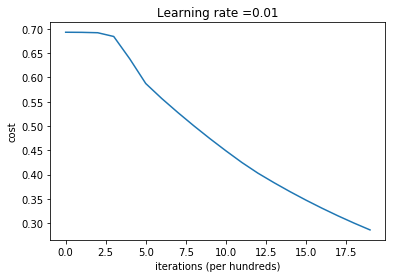

In [87]:
trained_model = L_layer_model(X_train, Y_train, layer_dims=layer_dims, learning_rate = 0.01, activations="relu", final_activ="sigmoid", num_iterations=num_iterations,)

### Predict

In [88]:
def test_pred(X, Y, params):
    """
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    p = np.zeros((1,m))

    # Forward propagation
    probas, caches = L_model(X, params, activations, final_activ)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p[0] == Y[0]))/m))

    return p

In [89]:
print("my preds", test_pred(X_test, Y_test, trained_model))
print("Y_test", Y_test)

Accuracy: 0.87
my preds [[0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
  0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1.
  1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
  0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
  0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
  0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1.
  0. 1. 1. 1. 0. 0. 1. 0.]]
Y_test [[0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0
  0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0
  0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1
  1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1
  1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1

### Next phases

- Comprendre pourquoi l'accuracy ne change pas lorsqu'on fait varier le l_r
- Complexifier le dataset : Tester avec un dataset où l'étiquette est 1 dans [0:20] et [80:100]
- Tester avec un dataset avec plusieurs features (ex : XOR)